# Very naive learning on the vector of surrounding bases with xgboost

---


### Data

Naive feature vectors. The original sequence of validation/test and train data does not overlap! ( but train data points can overlap with train data points, and test-validation can overlap with test-validation data ) This overlapping does not lead to unintentional label leakage!



### Analysis

I will try to naively predict the mehtylation value (0,1) based on naive sequence context feauture vectors.

I will use xgboost, a sophisticated library for gradient boosting, which is used to win many kaggle competitions.
    



### Conlcusions

---

In [1]:
import numpy as np
import time
import xgboost as xgb

import sys
sys.path.append('../my_modules/')
from loading_utils import read_my_data,create_sets

import os,subprocess
workdir='/nagyvinyok/adat84/sotejedlik/ribli/methylation_code/modelling'
subprocess.call(['mkdir',workdir])
os.chdir(workdir)

### Load data

In [2]:
_,train_x,train_y = read_my_data(fname='../prepare_data/big_train_feat_vect.csv')
train_id,test_x,test_y = read_my_data(fname='../prepare_data/big_test_feat_vect.csv')

Loading data... 
Loading data... 


In [3]:
N_val=20000
valid_x,valid_y=train_x[-N_val:],train_y[-N_val:]
train_x,train_y=train_x[:-N_val],train_y[:-N_val]

#### Create xgboost matrices

In [4]:
dtrain = xgb.DMatrix( train_x, label=train_y)
dvalid = xgb.DMatrix( valid_x, label=valid_y)
dtest = xgb.DMatrix( test_x, label=test_y)

### Train

In [5]:
param = {'max_depth':4,
         'eta':0.1,
         'min_child_weight':50,
         'colsample_bytree':0.8,
         'subsample':0.6,
         'silent':1,
         'objective': "binary:logistic",
         'eval_metric': 'error',
         'nthread':14}

evallist  = [(dtrain,'train'),(dvalid,'eval')]

#train
num_round = 5000
bst = xgb.train(param,
                dtrain,
                evals=evallist,
                num_boost_round=num_round,
                early_stopping_rounds=100,
                verbose_eval=50)

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-error:0.411038	eval-error:0.413050
[50]	train-error:0.245622	eval-error:0.248750
[100]	train-error:0.228572	eval-error:0.234400
[150]	train-error:0.220570	eval-error:0.228200
[200]	train-error:0.215510	eval-error:0.224450
[250]	train-error:0.208218	eval-error:0.216450
[300]	train-error:0.201557	eval-error:0.210950
[350]	train-error:0.193375	eval-error:0.205200
[400]	train-error:0.186122	eval-error:0.198550
[450]	train-error:0.179481	eval-error:0.194600
[500]	train-error:0.172487	eval-error:0.188550
[550]	train-error:0.165895	eval-error:0.181900
[600]	train-error:0.159259	eval-error:0.176950
[650]	train-error:0.153734	eval-error:0.171750
[700]	train-error:0.148752	eval-error:0.166950
[750]	train-error:0.143383	eval-error:0.163050
[800]	train-error:0.138758	eval-error:0.159900
[850]	train-error:0.133840	eval-error:0.156700
[900]	train-error:0.130238	eval-error:0.154000
[950]	train-error:0.126460	eval-error:0.152350
[10

#### Final scores

In [7]:
print 'train score:',list(map(round,bst.predict(dtrain))==train_y).count(True)/float(len(train_y))
print 'validation score:',list(map(round,bst.predict(dvalid))==valid_y).count(True)/float(len(valid_y))
print 'test score:',list(map(round,bst.predict(dtest))==test_y).count(True)/float(len(test_y))

train score: 0.927094854503
validation score: 0.8746
test score: 0.8791


### Feature importance

In [7]:
fscore=bst.get_fscore()

vals=[0 for i in xrange(1000)]
for key,val in fscore.iteritems():
    vals[int(key[1:])]=val

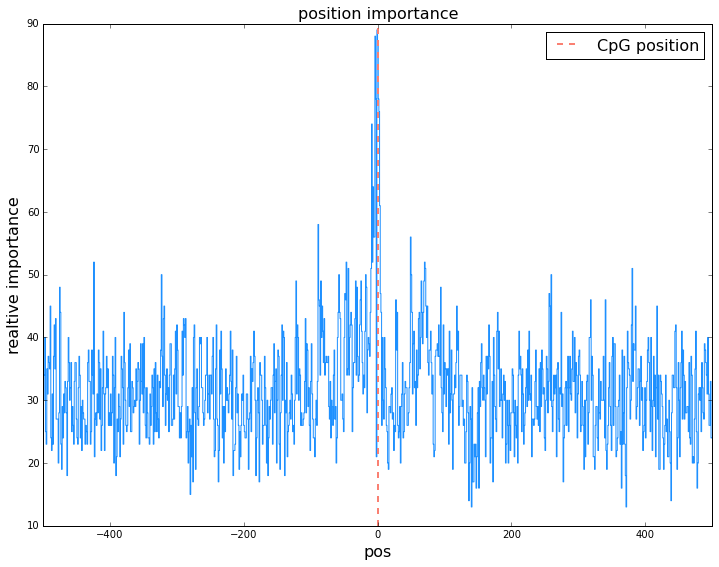

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax=plt.subplots()
fig.set_size_inches(12,9)
ax.step(np.arange(len(vals))-500, vals,lw=1,c='dodgerblue')
ax.axvline(0,lw=2,linestyle='dashed',c='salmon',label='CpG position')
ax.set_ylabel('realtive importance',fontsize=16)
ax.set_xlabel('pos',fontsize=16)
ax.set_xlim(-500,500)
ax.legend(fontsize=16)
dump=ax.set_title('position importance',fontsize=16)